In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [23]:
##obj = pickle.loads(obj = pickle.loads(cifar10_train.pkl))
import pickle
input = open('cifar10_train.pkl', 'rb')
obj = pickle.load(input, encoding="bytes")
input.close()


In [54]:
output = open('data1.pkl', 'wb')
pickle.dump(obj, output)
output.close()


In [3]:
from sklearn.externals import joblib


data = joblib.load('data1.pkl')
print('number of samples: ', len(data[b"images"]))
print('image shape: ', data[b"images"][0].shape)
print('labels:', np.unique(data[b"labels"]))

number of samples:  50000
image shape:  (32, 32, 3)
labels: [0 1 2 3 4 5 6 7 8 9]


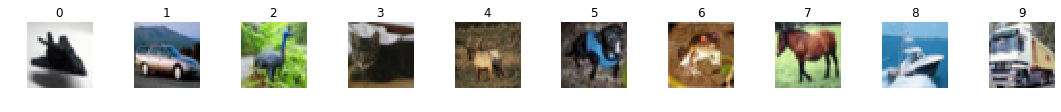

In [4]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data[b"labels"])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data[b"labels"].index(label)
 
    ax.imshow(data[b"images"][idx])
    ax.axis('off')
    ax.set_title(label)

In [5]:
X = np.array(data[b"images"])
y = np.array(data[b"labels"])

In [6]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

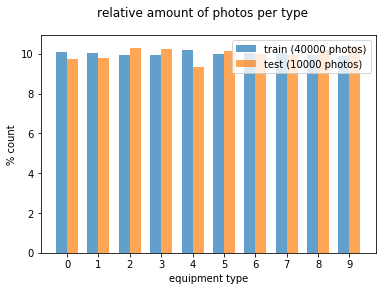

In [7]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'test ({0} photos)'.format(len(y_test))
]);

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(40000, 324)


In [10]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [12]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True False False  True False  True False  True False  True  True
  True False False False False  True False False  True False False False
 False]

Percentage correct:  43.9


In [13]:
import pandas as pd
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions],
    columns=['true_label', 'prediction']
)
df

from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


In [14]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[447,  48, 124,  20,  32,  24,  17,  54, 161,  46],
       [ 35, 570,  36,  28,  37,   8,  36,  51,  69, 109],
       [102,  35, 403,  48, 100, 107, 101,  64,  48,  22],
       [ 35,  49, 197, 189, 114, 160, 141,  76,  27,  35],
       [ 29,  40, 111,  66, 283,  84, 134, 104,  28,  54],
       [ 14,  40, 236,  90,  96, 326,  92,  65,  18,  38],
       [ 27,  52,  66,  51,  63,  76, 594,  33,  16,  18],
       [ 14,  42,  98,  49, 107, 124,  33, 473,  15,  39],
       [ 96, 120,  54,  32,  22,  14,  31,  37, 508, 103],
       [ 24, 143,  23,  36,  43,  23,  22,  65,  64, 597]], dtype=int64)


 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


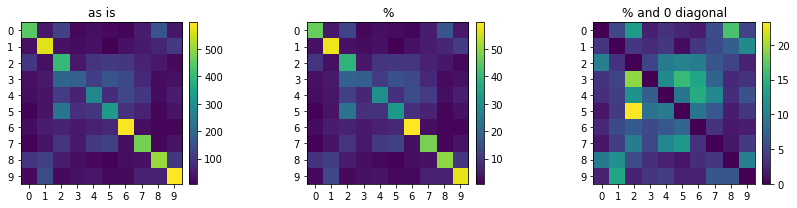

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(10)) for a in ax]
    [a.set_yticks(range(10)) for a in ax]
 
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1)
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
 
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In [16]:

from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8),
        cells_per_block=(2,2),
        orientations=9,
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  43.9


In [17]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {'hogify__orientations': [9],
    'hogify__cells_per_block': [(3, 3)],
    'hogify__pixels_per_cell': [(8, 8), (14, 14)]},
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(3, 3)],
     'hogify__pixels_per_cell': [(14, 14)],
     'classify': [
         SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
         svm.SVC(kernel='linear')]}
]

In [18]:
grid_search = GridSearchCV(HOG_pipeline,
                           param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   15.4s remaining:  1.3min


ValueError: Found array with 0 feature(s) (shape=(26662, 0)) while a minimum of 1 is required by StandardScaler.

NameError: name 'grid_res' is not defined